In [18]:

from SourceFiles.teproteus import TEProteusAdmin as TepAdmin
import matplotlib.pyplot as plt
import numpy as np
import time
################################################################################
# connect and initialize
admin = TepAdmin() #required to control PXI module
sid = 8 #PXI slot WDS found
inst = admin.open_instrument(slot_id=sid)
resp = inst.send_scpi_query("*IDN?")
print('connected to: ' + resp) # Print *IDN
inst.send_scpi_cmd('*CLS; *RST')

#Set rates for DAC
# sampleRateDAC = 1.125E9
sampleRateDAC = 1E9
#Set CF
ncoFreq= 100E6
################################################################################
#wavefore parameters
max_dac=65535 # Max Dac
half_dac=max_dac/2 # DC Level
data_type = np.uint16 # DAC data type
onLen = 32 * 20 # Pulse on time multiple of 32 or 28ns
segTime = onLen / (sampleRateDAC)
print('On time')
print(segTime)
dacWaveOn_I = np.ones(onLen)
dacWaveOn_I = dacWaveOn_I * max_dac
dacWaveOn_I = dacWaveOn_I.astype(data_type)
dacWaveOn_Q = dacWaveOn_I
# reshapes for IQIQIQIQIQ....
arr_tuple = (dacWaveOn_I, dacWaveOn_Q)
dacWaveOn_IQ = np.vstack(arr_tuple).reshape((-1,), order='F')
offLen = 32
dacWaveOff_I = np.ones(offLen)
dacWaveOff_I = dacWaveOff_I * half_dac
dacWaveOff_I = dacWaveOff_I.astype(data_type)
dacWaveOff_Q = dacWaveOff_I
# reshapes for IQIQIQIQIQ....
arr_tuple = (dacWaveOff_I, dacWaveOff_Q)
dacWaveOff_IQ = np.vstack(arr_tuple).reshape((-1,), order='F')
################################################################################
#AWG channel
ch = 1 # everythinf after relates to CH 1
cmd = ':INST:CHAN {0}'.format(ch)
inst.send_scpi_cmd(cmd)
cmd = ':FREQ:RAST {0}'.format(2.5E9) # force to max 16 bit DAC
inst.send_scpi_cmd(cmd)
inst.send_scpi_cmd(':INIT:CONT OFF')
inst.send_scpi_cmd(':TRAC:DEL:ALL')
inst.send_scpi_cmd(':TRIG:SOURce:ENAB {}'.format('TRG1'))
inst.send_scpi_cmd(':TRIG:SELECT {}'.format('TRG1'))
inst.send_scpi_cmd(':TRIG:LTJ ON')
inst.send_scpi_cmd(':TRIG:LEV 0.5')
inst.send_scpi_cmd(':TRIG:DEL 0E-9')
inst.send_scpi_cmd(':TRIG:SLOP POS')
inst.send_scpi_cmd(':TRIG:COUP OFF')
inst.send_scpi_cmd(':TRIGger:STAT ON')
resp = inst.send_scpi_query(':SYST:ERR?')
print("End of trig Error = ")
print(resp)
################################################################################
# Define segment memory
segnum = 1
cmd = ':TRAC:DEF {0}, {1}'.format(segnum, len(dacWaveOn_IQ))
inst.send_scpi_cmd(cmd)
# Select the segment
cmd = ':TRAC:SEL {0}'.format(segnum)
inst.send_scpi_cmd(cmd)
# Increase the timeout before writing binary-data:
inst.timeout = 30000
# Send the binary-data with *OPC? added to the beginning of its prefix.
inst.write_binary_data('*OPC?; :TRAC:DATA', dacWaveOn_IQ)
# Set normal timeout
inst.timeout = 10000
resp = inst.send_scpi_query(':SYST:ERR?')
print("Trace Download Error = ")
print(resp)
# Define segment memory
segnum = 2
cmd = ':TRAC:DEF {0}, {1}'.format(segnum, len(dacWaveOff_IQ))
inst.send_scpi_cmd(cmd)
# Select the segment
cmd = ':TRAC:SEL {0}'.format(segnum)
inst.send_scpi_cmd(cmd)
# Increase the timeout before writing binary-data:
inst.timeout = 30000
# Send the binary-data with *OPC? added to the beginning of its prefix.
inst.write_binary_data('*OPC?; :TRAC:DATA', dacWaveOff_IQ)
# Set normal timeout
inst.timeout = 10000
resp = inst.send_scpi_query(':SYST:ERR?')
print("Trace Download Error = ")
print(resp)
################################################################################
cmd = ':SOUR:MODE DUC'
resp = inst.send_scpi_cmd(cmd)
cmd = ':SOUR:INT X8'
resp = inst.send_scpi_cmd(cmd)
cmd = ':SOUR:IQM ONE'
resp = inst.send_scpi_cmd(cmd)
sampleRateDACInt = sampleRateDAC * 8
print('Interpolated Sample Clk Freq {0}'.format(sampleRateDACInt))
cmd = ':FREQ:RAST {0}'.format(sampleRateDACInt)
resp = inst.send_scpi_cmd(cmd)
resp = inst.send_scpi_query(':SYST:ERR?')
print("IQ Set Error = ")
print(resp)
cmd = ':SOUR:NCO:CFR1 {0}'.format(ncoFreq)
resp = inst.send_scpi_cmd(cmd)
print('NCO CF: {0}'.format(ncoFreq))
################################################################################
#Direct RF Output CH
cmd = ':INST:CHAN {0}'.format(ch)
inst.send_scpi_cmd(cmd)
cmd = ':TASK:COMP:LENG 3'
inst.send_scpi_cmd(cmd)
cmd = ':TASK:COMP:SEL 1'
inst.send_scpi_cmd(cmd)
cmd = ':TASK:COMP:SEGM 2'
inst.send_scpi_cmd(cmd)
cmd = ':TASK:COMP:ENAB {}'.format("TRG1")
inst.send_scpi_cmd(cmd)
cmd = ':TASK:COMP:NEXT1 2'
inst.send_scpi_cmd(cmd)
cmd = ':TASK:COMP:SEL 2'
inst.send_scpi_cmd(cmd)
cmd = ':TASK:COMP:SEGM 1'
inst.send_scpi_cmd(cmd)
cmd = ':TASK:COMP:DTR ON'
inst.send_scpi_cmd(cmd)
cmd = ':TASK:COMP:LOOP 1'
inst.send_scpi_cmd(cmd)
cmd = ':TASK:COMP:NEXT1 3'
inst.send_scpi_cmd(cmd)
cmd = ':TASK:COMP:SEL 3'
inst.send_scpi_cmd(cmd)
cmd = ':TASK:COMP:SEGM 2'
inst.send_scpi_cmd(cmd)
cmd = ':TASK:COMP:LOOP 1'
inst.send_scpi_cmd(cmd)
cmd = ':TASK:COMP:NEXT1 1'
inst.send_scpi_cmd(cmd)
cmd = ':TASK:COMP:WRITE'
inst.send_scpi_cmd(cmd)
cmd = ':SOUR:FUNC:MODE TASK'
inst.send_scpi_cmd(cmd)
cmd = ':OUTP ON'
rc = inst.send_scpi_cmd(cmd)
resp = inst.send_scpi_query(':SYST:ERR?')
print("End of CH1 Gen Error = ")
print(resp)
################################################################################
#AWG channel
ch = 3 # everythinf after relates to CH 2
cmd = ':INST:CHAN {0}'.format(ch)
inst.send_scpi_cmd(cmd)
cmd = ':FREQ:RAST {0}'.format(2.5E9) # force to max 16 bit DAC
inst.send_scpi_cmd(cmd)
inst.send_scpi_cmd(':INIT:CONT ON')
inst.send_scpi_cmd(':TRIG:SOURce:ENAB {}'.format('TRG1'))
inst.send_scpi_cmd(':TRIG:SELECT {}'.format('TRG1'))
inst.send_scpi_cmd(':TRIG:LTJ ON')
inst.send_scpi_cmd(':TRIG:LEV 0.5')
inst.send_scpi_cmd(':TRIG:DEL 0E-9')
inst.send_scpi_cmd(':TRIG:SLOP POS')
inst.send_scpi_cmd(':TRIG:COUP OFF')
inst.send_scpi_cmd(':TRIGger:STAT ON')
# inst.send_scpi_cmd(':TRAC:DEL:ALL')
################################################################################
# Define segment memory
segnum = 3
cmd = ':TRAC:DEF {0}, {1}'.format(segnum, len(dacWaveOn_IQ))
inst.send_scpi_cmd(cmd)
# Select the segment
cmd = ':TRAC:SEL {0}'.format(segnum)
inst.send_scpi_cmd(cmd)
# Increase the timeout before writing binary-data:
inst.timeout = 30000
# Send the binary-data with *OPC? added to the beginning of its prefix.
inst.write_binary_data('*OPC?; :TRAC:DATA', dacWaveOn_IQ)
# Set normal timeout
inst.timeout = 10000
resp = inst.send_scpi_query(':SYST:ERR?')
print("Trace Download Error = ")
print(resp)
# Define segment memory
segnum = 4
cmd = ':TRAC:DEF {0}, {1}'.format(segnum, len(dacWaveOff_IQ))
inst.send_scpi_cmd(cmd)
# Select the segment
cmd = ':TRAC:SEL {0}'.format(segnum)
inst.send_scpi_cmd(cmd)
# Increase the timeout before writing binary-data:
inst.timeout = 30000
# Send the binary-data with *OPC? added to the beginning of its prefix.
inst.write_binary_data('*OPC?; :TRAC:DATA', dacWaveOff_IQ)
# Set normal timeout
inst.timeout = 10000
resp = inst.send_scpi_query(':SYST:ERR?')
print("Trace Download Error = ")
print(resp)
################################################################################
cmd = ':SOUR:MODE DUC'
resp = inst.send_scpi_cmd(cmd)
cmd = ':SOUR:INT X8'
resp = inst.send_scpi_cmd(cmd)
cmd = ':SOUR:IQM ONE'
resp = inst.send_scpi_cmd(cmd)
sampleRateDACInt = sampleRateDAC * 8
print('Interpolated Sample Clk Freq {0}'.format(sampleRateDACInt))
cmd = ':FREQ:RAST {0}'.format(sampleRateDACInt)
resp = inst.send_scpi_cmd(cmd)
resp = inst.send_scpi_query(':SYST:ERR?')
print("IQ Set Error = ")
print(resp)
cmd = ':SOUR:NCO:CFR1 {0}'.format(ncoFreq)
resp = inst.send_scpi_cmd(cmd)
print('NCO CF: {0}'.format(ncoFreq))
################################################################################
#Direct RF Output CH
cmd = ':INST:CHAN {0}'.format(ch)
inst.send_scpi_cmd(cmd)
cmd = ':TASK:COMP:LENG 3'
inst.send_scpi_cmd(cmd)
cmd = ':TASK:COMP:SEL 1'
inst.send_scpi_cmd(cmd)
cmd = ':TASK:COMP:SEGM 4'
inst.send_scpi_cmd(cmd)
cmd = ':TASK:COMP:ENAB {}'.format("TRG1")
inst.send_scpi_cmd(cmd)
cmd = ':TASK:COMP:NEXT1 2'
inst.send_scpi_cmd(cmd)
cmd = ':TASK:COMP:SEL 2'
inst.send_scpi_cmd(cmd)
cmd = ':TASK:COMP:SEGM 3'
inst.send_scpi_cmd(cmd)
cmd = ':TASK:COMP:DTR ON'
inst.send_scpi_cmd(cmd)
cmd = ':TASK:COMP:LOOP 1'
inst.send_scpi_cmd(cmd)
cmd = ':TASK:COMP:NEXT1 3'
inst.send_scpi_cmd(cmd)
cmd = ':TASK:COMP:SEL 3'
inst.send_scpi_cmd(cmd)
cmd = ':TASK:COMP:SEGM 4'
inst.send_scpi_cmd(cmd)
cmd = ':TASK:COMP:LOOP 1'
inst.send_scpi_cmd(cmd)
cmd = ':TASK:COMP:NEXT1 1'
inst.send_scpi_cmd(cmd)
cmd = ':TASK:COMP:WRITE'
inst.send_scpi_cmd(cmd)
cmd = ':SOUR:FUNC:MODE TASK'
inst.send_scpi_cmd(cmd)
cmd = ':OUTP ON'
rc = inst.send_scpi_cmd(cmd)
resp = inst.send_scpi_query(':SYST:ERR?')
print("End of CH2 Gen Error = ")
print(resp)
################################################################################

################################################################################

# Start the digitizer
# initialize DAC and take the first capture.
#Set number of frames to be collected
numframes, framelen = 1, 4800 # remember multiple of 96
totlen = numframes * framelen
print('Waveform Length {0}'.format(totlen))
wav1 = np.zeros(totlen, dtype=np.uint32)
sampleRateADC = sampleRateDACInt / 4
cmd = ':DIG:MODE DUAL'
inst.send_scpi_cmd(cmd)
print('ADC Clk Freq {0}'.format(sampleRateADC))
cmd = ':DIG:FREQ  {0}'.format(sampleRateADC)
inst.send_scpi_cmd(cmd)
print('Aquisition Length {0}'.format(framelen/2/sampleRateADC*16)) # x16 decimation
resp = inst.send_scpi_query(':DIG:FREQ?')
print("Dig Frequency = ")
print(resp)
# Enable capturing data from channel 1
cmd = ':DIG:CHAN:SEL 1'
inst.send_scpi_cmd(cmd)
resp = inst.send_scpi_query(':SYST:ERR?')
print("Dig error = ")
print(resp)
cmd = ':DIG:DDC:MODE COMP'   # DDC activation to complex i+jq
inst.send_scpi_cmd(cmd)
cmd = ':DIG:DDC:CFR1 {0}'.format(ncoFreq)
inst.send_scpi_cmd(cmd)
cmd = ':DIG:DDC:PHAS1 0'
inst.send_scpi_cmd(cmd)
cmd = ':DIG:DDC:CLKS AWG'
rc = inst.send_scpi_cmd(cmd)
resp = inst.send_scpi_query(':SYST:ERR?')
print("Set complex error = ")
print(resp)
cmd = ':DIG:CHAN:STATE ENAB'
inst.send_scpi_cmd(cmd)
# trigger from the task list
cmd = ':DIG:TRIG:SOURCE TASK1'
inst.send_scpi_cmd(cmd)
dig_system_delay=560E-9
cmd=':INST:CHAN:SEL 1'
inst.send_scpi_cmd(cmd)
# need to set the delay for individual output channel
cmd = ':DIG:TRIG:AWG:TDEL {0}'.format(dig_system_delay)
inst.send_scpi_cmd(cmd)
cmd = ':DIG:ACQuire:FRAM:DEF {0},{1}'.format(numframes, framelen)
inst.send_scpi_cmd(cmd)
# Select the frames for the capturing
capture_first, capture_count = 1, numframes
cmd = ':DIG:ACQuire:FRAM:CAPT {0},{1}'.format(capture_first, capture_count)
inst.send_scpi_cmd(cmd)

Load TEProteus.dll from : C:\Windows\system32\TEProteus.dll
connected to: slot#: 8,
On time
6.4e-07
End of trig Error = 
0, no error
Trace Download Error = 
0, no error
Trace Download Error = 
0, no error
Interpolated Sample Clk Freq 8000000000.0
IQ Set Error = 
0, no error
NCO CF: 100000000.0
End of CH1 Gen Error = 
0, no error
Trace Download Error = 
0, no error
Trace Download Error = 
0, no error
Interpolated Sample Clk Freq 8000000000.0
IQ Set Error = 
0, no error
NCO CF: 100000000.0
End of CH2 Gen Error = 
0, no error
Waveform Length 4800
ADC Clk Freq 2000000000.0
Aquisition Length 1.92e-05
Dig Frequency = 
2000000000.000
Dig error = 
0, no error
Set complex error = 
0, no error


0

In [19]:

inst.send_scpi_cmd(':DIG:INIT OFF')

inst.send_scpi_cmd(':DIG:INIT ON')

cmd = '*TRG'

inst.send_scpi_cmd(cmd)

 

frameRx = 0

times = 0

while (frameRx != 1):

    resp = inst.send_scpi_query(':DIG:ACQuire:FRAM:STATus?')

    framesParam = resp.split(",")

    frameRx = int(framesParam[1])

    times += 1

    time.sleep(0.1)

    # if times > 100:

    #     break

    #     # end time and print time

    print(resp)

inst.send_scpi_cmd(':DIG:INIT OFF')



1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,1,0,1


0

Total read size in bytes: 19200

4800
2400
2400


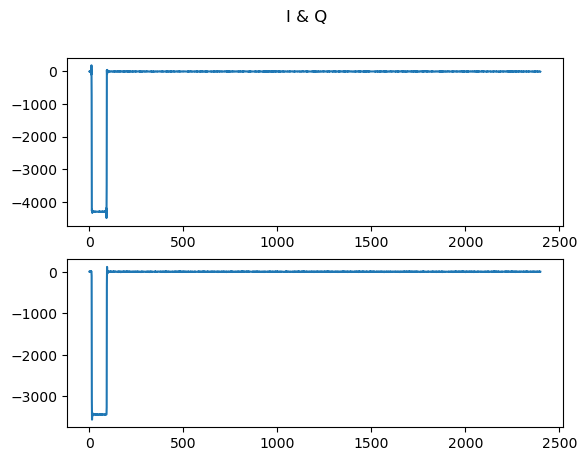

In [20]:
################################################################################
# Choose which frames to read (all in this example)
cmd = ':DIG:DATA:SEL ALL'
inst.send_scpi_cmd(cmd)
# Choose what to read
# (only the frame-data without the header in this example)
cmd = ':DIG:DATA:TYPE FRAM'
inst.send_scpi_cmd(cmd)
# Get the total data size (in bytes)
resp = inst.send_scpi_query(':DIG:DATA:SIZE?')
num_bytes = np.uint32(resp)
print('Total read size in bytes: ' + resp)
print()
# Read the data that was captured by channel 1:
inst.send_scpi_cmd(':DIG:CHAN:SEL 1')
wavlen = num_bytes // 2
rc = inst.read_binary_data(':DIG:DATA:READ?', wav1, wavlen)
cmd=':DIG:ACQ:ZERO:ALL 0'
inst.send_scpi_cmd(cmd)
################################################################################
wav1 = np.int32(wav1) - 16384
print(len(wav1))
wavlen = int(len(wav1)/2)
wavI=wav1[0::2]
wavQ=wav1[1::2]
wavI = wavI.astype(float)
wavQ = wavQ.astype(float)
print(len(wavI))
print(len(wavQ))
fig, axs = plt.subplots(2)
fig.suptitle('I & Q')
axs[0].plot(wavI)
axs[1].plot(wavQ)
plt.show()

In [4]:
from scipy.signal import butter,filtfilt
def butterwort(sampling_rate,cut_off_freq,signal_input):
    normalized_cutoff=2*cut_off_freq/sampling_rate
    b, a = butter(4, normalized_cutoff, btype='low', analog=False)
    filtered_signal = filtfilt(b, a, signal_input)
    return filtered_signal

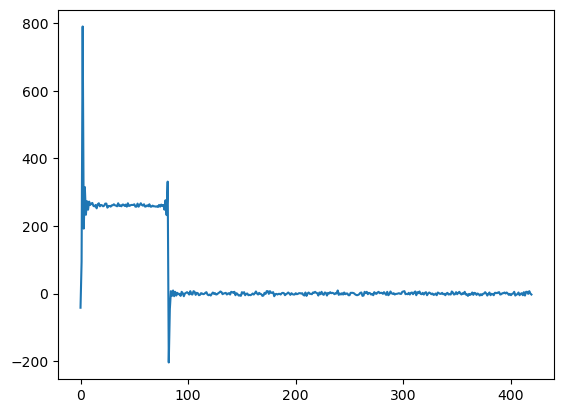

In [5]:
plt.plot(wavQ[80:500])

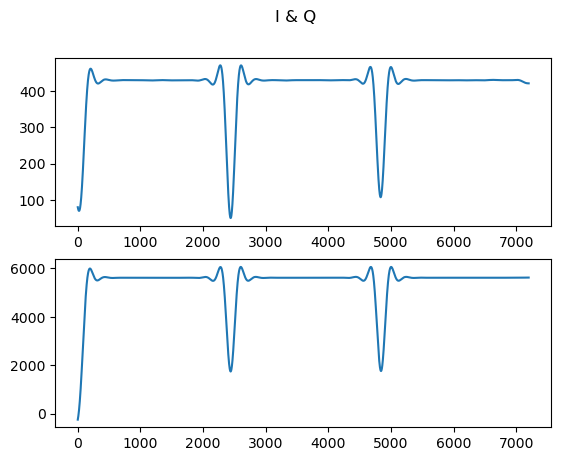

In [136]:
wavI_filter=butterwort(sampleRateADC,10E6,wavI)
wavQ_filter=butterwort(sampleRateADC,10E6,wavQ)
fig, axs = plt.subplots(2)
fig.suptitle('I & Q')
axs[0].plot(wavI_filter)
axs[1].plot(wavQ_filter)
plt.show()

In [113]:
inst.send_scpi_query(':DIG:DDC:DEC?')

'0'

Text(0.5, 1.0, 'I')

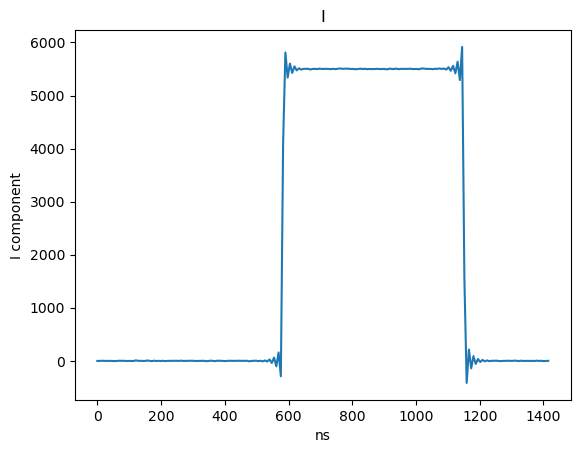

In [145]:
t=np.linspace(0,len(wavI)/sampleRateADC*16*1E9,len(wavI),endpoint=False)
plt.plot(t[0:200],wavI[0:200])
plt.xlabel('ns')
plt.ylabel('I component')
plt.title('I')

In [146]:
inst.send_scpi_query(':TRIG:LTJ?')

'ON'

In [58]:
15+10.5/16+0.31/2.54

15.778297244094489

In [60]:
13.65-5.38

8.27

In [61]:
8.27*2.54

21.0058

In [62]:
15.78-5.38

10.399999999999999

In [63]:
10.4*2.54

26.416

In [64]:
21-2/16-1/2

20.375

In [18]:
inst.send_scpi_query(':DIGitizer:DDC:DECimation?')

'X16'

In [19]:
16*80/(9E9/4)

5.688888888888889e-07